In [1]:
#hack till I make it a real package..
import os
import sys
sys.path.append("../../")
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import jax 
import jax.numpy as jnp

jax.config.update('jax_disable_jit', False)
import diffhydro as dh
from diffhydro.utils.io import athinput,athdf


In [2]:
#load athena ICs
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

athena_outputs_loc = "/home/ben.horowitz/DiffHydro/tests/athena_ref_outputs/blast/"

ic_filename = "Blast.out2.00000.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)



In [3]:

sol = jnp.zeros((5,100,100,100))
sol = sol.at[0].set(ICs["dens"])
sol = sol.at[-1].set(ICs["Etot"])

2025-10-24 11:41:51.790034: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
eq = dh.equationmanager.EquationManager()
#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))
hydrosim = dh.hydro(n_super_step=int(98),fluxes=[cf])#splitting_schemes=[[2,1,1,2],[1,2,2,1],])

In [5]:

params = {}
q = hydrosim.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


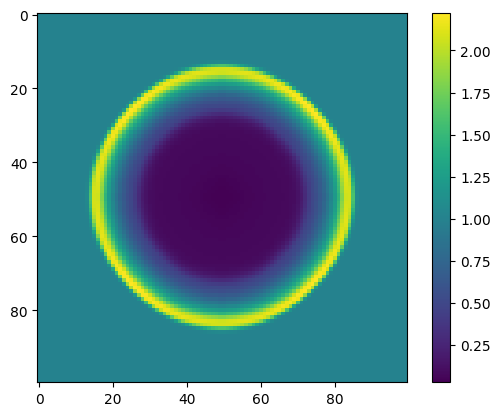

In [6]:
%pylab inline
imshow(q[0][0][50])
colorbar()

In [7]:
lt_filename = "Blast.out2.00217.athdf"

lt_file = h5py.File(athena_outputs_loc+lt_filename, 'r')

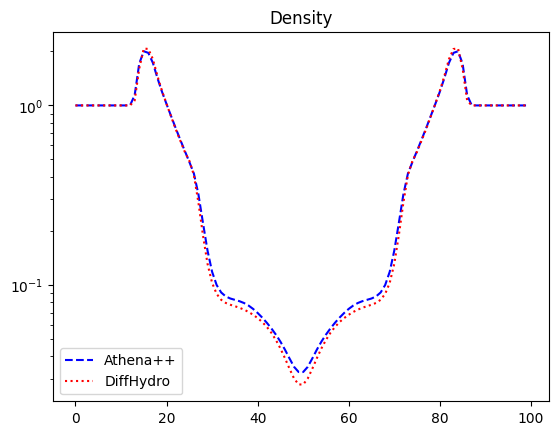

In [8]:
plt.semilogy(lt_file['cons'][0,0][50,50],"b--",label="Athena++")
plt.semilogy(q[0][0][50,50],"r:",label="DiffHydro")
plt.title("Density")
plt.legend()

Energy Profile


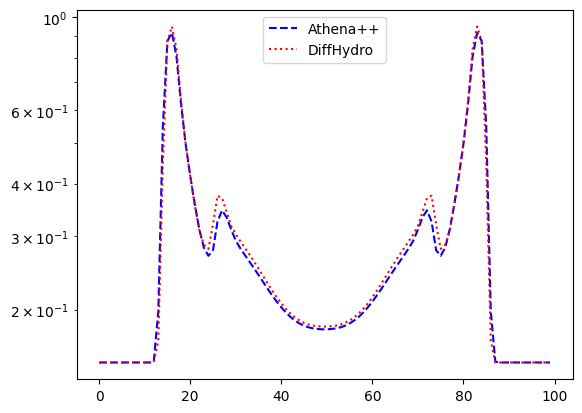

In [9]:
print("Energy Profile")
plt.semilogy(lt_file['cons'][1,0][50,50],"b--",label="Athena++")
plt.semilogy(q[0][-1][50,50],"r:",label="DiffHydro")
plt.legend()

In [10]:
#mol test

In [21]:
hydrosim = dh.hydro(n_super_step=int(97*2),fluxes=[cf],use_mol=True,integrator="SSPRK3") #timestep notation inconsistent between MOL and split
params = {}
q_MOL = hydrosim.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


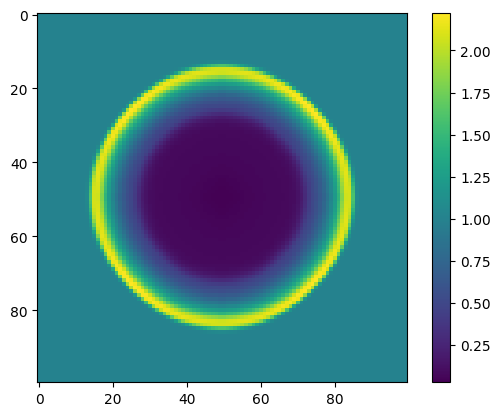

In [22]:
%pylab inline
imshow(q[0][0][50])
colorbar()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


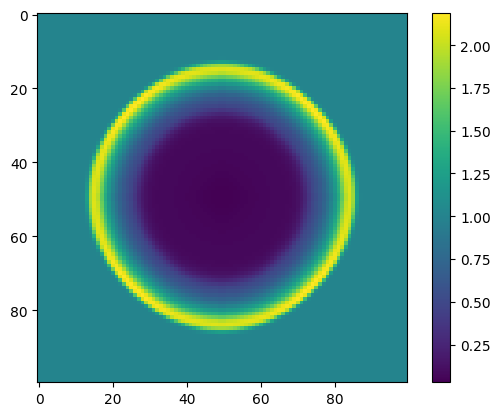

In [23]:
%pylab inline
imshow(q_MOL[0][0][50])
colorbar()

Energy Profile


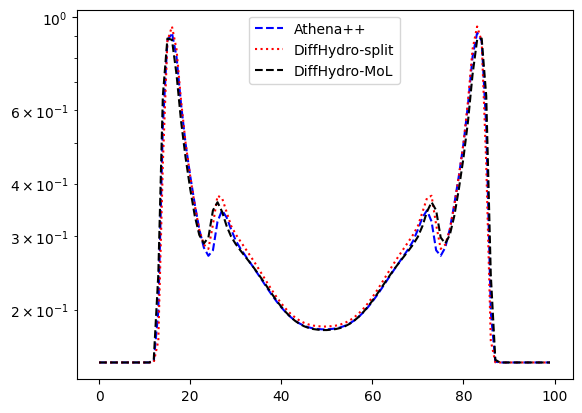

In [24]:
print("Energy Profile")
plt.semilogy(lt_file['cons'][1,0][50,50],"b--",label="Athena++")
plt.semilogy(q[0][-1][50,50],"r:",label="DiffHydro-split")
plt.semilogy(q_MOL[0][-1][50,50],"k--",label="DiffHydro-MoL")

plt.legend()